## Summarization demo

This example demonstrates the use of our work for producing query relevant video summaries in form of keyframes. The inputs to the model are a text query and the url of a video. The model outputs 5 query relevant keyframes from the video as a summary. The model comprises of four objective functions: Relevance, Interestingness, Diversity and Representativeness which jointly optimized. The weights of the objectives are optimized in order to maximize the F1 score (harmonic mean) between relevance precision and cluster recall.

The implementation is in Lasagne and Theano. For more details about the work, please refer

"Query-adaptive Video Summarization via Quality-aware Relevance Estimation" - ACM Multimedia 2017

### To start with:

Install the package: qvsumm
```
pip install requirements.txt
python setup.py install --user
```


In [6]:
### Download the trained weights of the models ###
import os
if not os.path.exists('data/vgg19.pkl'):
    !wget -P ./data/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/vgg19.tar.gz -nc
    !tar -xzvf ./data/vgg19.tar.gz -C ./data/ --skip-old-files
    !rm ./data/vgg19.tar.gz
!wget -P ./data/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/CNNmodel.npz -nc
!wget -P ./data/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/LSTMmodel.npz -nc
'''
Warning: The model below is of 10G. This is complete version. May take some time to download and unzip. 
For a smaller model, comment this and use the commented model further below.
'''
!wget -P ./data/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/word2vecmodel.tar.gz -nc
!mkdir ./data/word2vec
!tar -xzvf ./data/word2vecmodel.tar.gz -C ./data/word2vec/ --skip-old-files

## Small model, Use below one: This has a memory of 3.5G ##

#!wget -P ./data/word2vec/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/GoogleNews-vectors-negative300.bin -nc

--2017-04-21 17:41:18--  https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/CNNmodel.npz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4933158 (4.7M)
Saving to: ‘./data/CNNmodel.npz’

./data/CNNmodel.npz 100%[=====================>]   4.70M  3.91MB/s   in 1.2s   

2017-04-21 17:41:19 (3.91 MB/s) - ‘./data/CNNmodel.npz’ saved [4933158/4933158]

--2017-04-21 17:41:19--  https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/LSTMmodel.npz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3255346 (3.1M)
Saving to: ‘./data/LSTMmodel.npz’

./data/LSTMmodel.np 100%[=====================>]   3.10M  3.95MB/s   in 0.8s   

2017-04-21 17:41:20

'\nWarning: The model below is of 10G. This is complete version. May take some time to download and unzip. \nFor a smaller model, comment this and use the commented model further below.\n'

In [4]:
### Import our package ###
import qvsumm

Using gpu device 1: Tesla K20Xm (CNMeM is disabled, CuDNN 3008)
  "downsample module has been moved to the theano.tensor.signal.pool module.")



Loaded config file from qvsumm/config.ini
Loaded config file from qvsumm/config.ini


In [5]:
'''
Set and compile the relevance score function
On the GPU, the network will be using cuDNN layer implementations available in the Lasagne.

'''
relscore_function = qvsumm.get_QAR_function()

Load weights and compile Relevance model...
Set LSTM learned weights...
Set CNN learned weights...


In [6]:
### Load the word2vec model ###
w2vmodel = qvsumm.get_word2vec_function()

Load word2vec model...


In [12]:
# Inputs : Text query and YouTube URL of the video
videoURL="https://www.youtube.com/watch?v=ntza_9lbbc0"
query="cat fails"

In [13]:
# Preprocessing Data 
from qvsumm.utils_func import preprocess_video
imagenames= preprocess_video(query,videoURL)

In [8]:
### Compute the similarity and quality scores for all the frames of the video ###
relscores,intscores=qvsumm.get_rel_Q_scores(relscore_function, w2vmodel, query, imagenames)  

Scoring frames... 


In [9]:
'''
Summarization using submodular mixtures[1] having four objective functions: Interestingness, Relevance, Diversity, Representativeness

[1] Gygli, Grabner & Van Gool. Video Summarization by Learning Submodular Mixtures of Objectives. CVPR 2015.
''' 
from qvsumm.shells import *
K=5 ### Number of elements in the summary
S1=qvsumm.shells.Summ(query,imagenames,relscores,intscores)
S1.budget=K
objectives=[quality_shell(S1),similarity_shell(S1),diversity_shell(S1),ex.representativeness_shell(S1)]
weights=[0.00963344,  0.45267703,  0.43680236,  0.10088718 ]###weights for the objectives
selected_elements,score,_=gm_submodular.lazy_greedy_maximize(S1,weights,objectives,budget=K,randomize=True)

In [10]:
print selected_elements

[16, 12, 9, 21, 14]


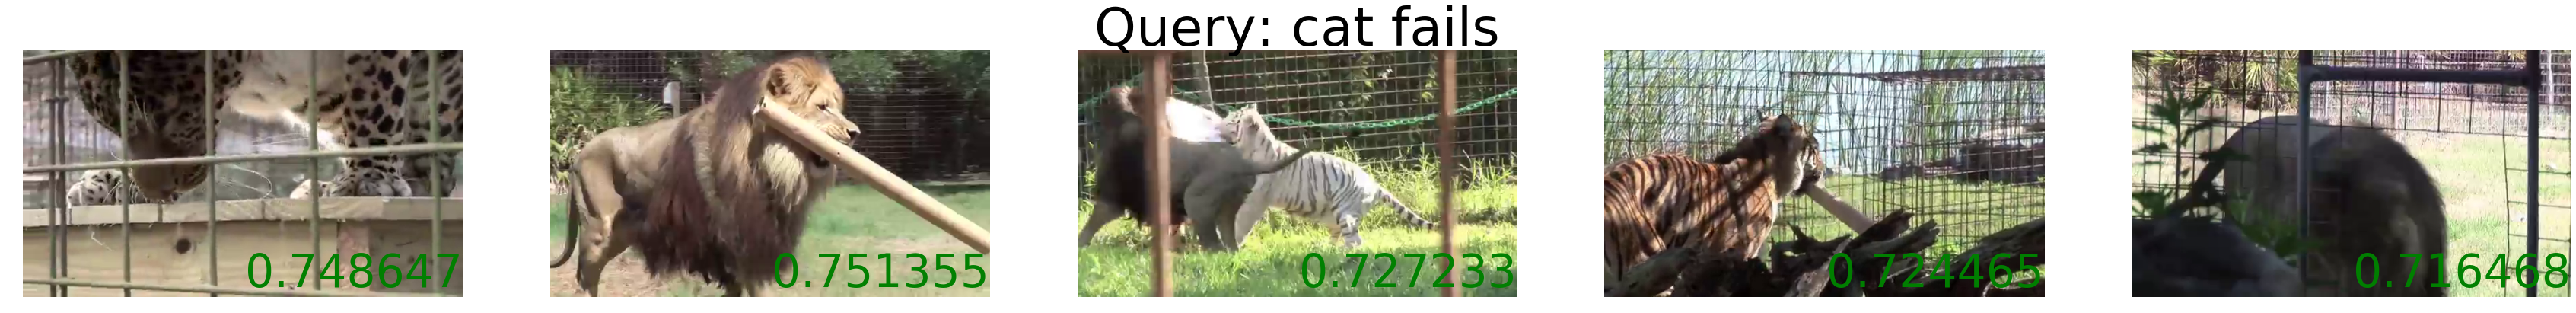

In [11]:
'''
We extract the 5 frames from the video.
'''
import matplotlib .pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
plt.figure(figsize=(60, 10))
for enum,i in enumerate(selected_elements[0:K]):
    if enum==3:
        plt.title("Query: "+str(query),fontsize=70)
    plt.subplot(1,K, enum+1);plt.imshow(mpimg.imread("videos/frames/"+str(i)+".png"));plt.axis('off')
    plt.annotate(str(relscores[i]), xy=(1, 0), xycoords='axes fraction', fontsize=60,
    horizontalalignment='right', verticalalignment='bottom',color='green')
plt.show()

This is the set of selected keyframes from the video as a summary for the given query: `Cat fails`. 